# Classify snow-covered area (SCA) in Sentinel-2, Landsat 8/9, and PlanetScope imagery: full pipelines

Rainey Aberle

Department of Geosciences, Boise State University

2022

### Requirements:
- Area of Interest (AOI) shapefile: where snow will be classified in all available images. 
- Google Earth Engine (GEE) account: used to pull DEM over the AOI. Sign up for a free account [here](https://earthengine.google.com/new_signup/). 
- Digital elevation model (DEM) (_optional_): used to extract elevations over the AOI and for each snowline. If no DEM is provided, the ASTER Global DEM will be loaded through GEE. 

### Outline:
__0. Setup__ paths in directory, file locations, authenticate GEE - _modify this section!_

__1. Sentinel-2 Top of Atmosphere (TOA) imagery:__ full pipeline

__2. Sentinel-2 Surface Reflectance (SR) imagery:__ full pipeline

__3. Landsat 8/9 Surface Reflectance (SR) imagery:__ full pipeline

__4. PlanetScope Surface Reflectance (SR) imagery:__ full pipeline

-------


### 0. Setup

#### Define paths in directory and desired settings. 
Modify lines located within the following:

`#### MODIFY HERE ####`  

`#####################`

In [1]:
##### MODIFY HERE #####

# -----Paths in directory
site_name = 'Gulkana'
# path to snow-cover-mapping/ - Make sure you include a "/" at the end
base_path = '/Users/raineyaberle/Research/PhD/snow_cover_mapping/snow-cover-mapping/'
# path to AOI including the name of the shapefile
AOI_path = '/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/' + site_name + '/AOIs/'
# AOI file name
AOI_fn =  'Gulkana_USGS_glacier_outline_2021.shp'
# path to DEM including the name of the tif file
# Note: set DEM_path==None and DEM_fn=None if you want to use the ASTER GDEM via Google Earth Engine
DEM_path = AOI_path + '../DEMs/'
# DEM file name
DEM_fn = None#'Gulkana_20210919_DEM_filled.tif'
# path for output images
out_path = AOI_path + '../imagery/'
# path to PlanetScope images
# Note: set PS_im_path=None if not using PlanetScope
PS_im_path = out_path + 'PlanetScope/raw_images/'
# path for output figures
figures_out_path = AOI_path + '../figures/'

# -----Define image search filters
date_start = '2013-05-01'
date_end = '2023-01-01'
month_start = 5
month_end = 11
cloud_cover_max = 70

# -----Determine whether to mask clouds using the respective cloud masking data products
# NOTE: Cloud mask products anecdotally are less accurate over glacierized/snow-covered surfaces. 
# If the cloud masks are consistently masking large regions or your study site, I suggest setting mask_clouds = False
mask_clouds = False

# -----Determine clipping & plotting settings
plot_results = True # = True to plot figures of results for each image where applicable
skip_clipped = False # = True to skip images where bands appear "clipped", i.e. max(blue) < 0.8
crop_to_AOI = True # = True to crop images to AOI before calculating SCA
save_outputs = True # = True to save SCAs and snowlines to file
save_figures = True # = True to save SCA output figures to file

#######################

# -----Import packages
import xarray as xr
import os
import numpy as np
import glob
from matplotlib import pyplot as plt, dates
import matplotlib
import rasterio as rio
import geopandas as gpd
import pandas as pd
import sys
import ee
import geedim as gd
import pickle
import time
from tqdm.auto import tqdm
from joblib import dump, load

# -----Set paths for output files
PS_im_masked_path = out_path + 'PlanetScope/masked/'
PS_im_mosaics_path = out_path + 'PlanetScope/mosaics/'
S2_im_path = out_path + 'Sentinel-2/'
L_im_path = out_path + 'Landsat/'
im_classified_path = out_path + 'classified/'
snowlines_path = out_path + 'snowlines/'

# -----Add path to functions
sys.path.insert(1, base_path+'functions/')
import pipeline_utils as f

# -----Load dataset dictionary
with open(base_path + 'inputs-outputs/datasets_characteristics.pkl', 'rb') as fn:
    dataset_dict = pickle.load(fn)

#### Authenticate and initialize Google Earth Engine (GEE). 

__Note:__ The first time you run the following cell, you will be asked to authenticate your GEE account for use in this notebook. This will send you to an external web page, where you will walk through the GEE authentication workflow and copy an authentication code back into the space below this cell when prompted. 

In [2]:
try:
    gd.Initialize()
except: 
    gd.Authenticate()
    gd.Initialize()

#### Load AOI and DEM

Optimal UTM CRS = EPSG:32606
Clipped ArcticDEM already exists in directory, loading...
EPSG:32606


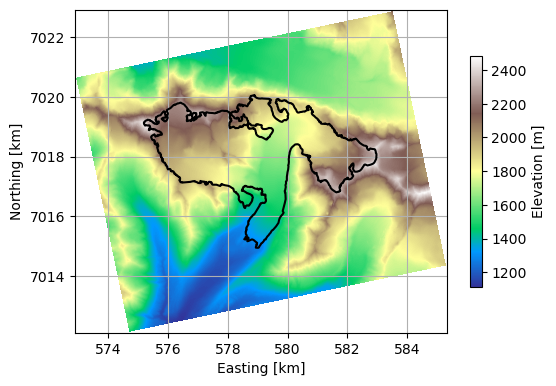

In [18]:
# -----Load AOI as gpd.GeoDataFrame
AOI = gpd.read_file(AOI_path + AOI_fn)
# reproject the AOI to WGS to solve for the optimal UTM zone
AOI_WGS = AOI.to_crs('EPSG:4326')
AOI_WGS_centroid = [AOI_WGS.geometry[0].centroid.xy[0][0],
                    AOI_WGS.geometry[0].centroid.xy[1][0]]
# grab the optimal UTM zone EPSG code
epsg_UTM = f.convert_wgs_to_utm(AOI_WGS_centroid[0], AOI_WGS_centroid[1])
print('Optimal UTM CRS = EPSG:' + str(epsg_UTM))

# -----Load DEM as Xarray DataSet
if DEM_fn==None:
    # query GEE for DEM
    DEM, AOI_UTM = f.query_GEE_for_DEM(AOI, base_path, site_name, DEM_path)
else:
    # reproject AOI to UTM
    AOI_UTM = AOI.to_crs('EPSG:'+str(epsg_UTM))
    # load DEM as xarray DataSet
    DEM = xr.open_dataset(DEM_path + DEM_fn)
    DEM = DEM.rename({'band_data': 'elevation'})
    # reproject the DEM to the optimal UTM zone
    DEM = DEM.rio.reproject('EPSG:'+str(epsg_UTM))
# remove unnecessary data (possible extra bands from ArcticDEM or other DEM)
if len(np.shape(DEM.elevation.data))>2:
    DEM['elevation'] = DEM.elevation[0]

# -----Plot
fig, ax = plt.subplots(1, 1, figsize=(6,6))
dem_im = ax.imshow(DEM.elevation.data, cmap='terrain', 
          extent=(np.min(DEM.x.data)/1e3, np.max(DEM.x.data)/1e3, np.min(DEM.y.data)/1e3, np.max(DEM.y.data)/1e3))
ax.plot([x/1e3 for x in AOI_UTM.geometry[0].exterior.coords.xy[0]],
        [y/1e3 for y in AOI_UTM.geometry[0].exterior.coords.xy[1]], '-k')
ax.grid()
ax.set_xlabel('Easting [km]')
ax.set_ylabel('Northing [km]')
fig.colorbar(dem_im, ax=ax, shrink=0.5, label='Elevation [m]')
plt.show()

## 1. Sentinel-2 TOA imagery

In [ ]:
print('Sentinel-2 TOA')
print('----------')

# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/Sentinel-2_TOA_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/Sentinel-2_TOA_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Query GEE for imagery
dataset = 'Sentinel-2_TOA'
im_list = f.query_GEE_for_Sentinel2(dataset, dataset_dict, site_name, AOI_UTM, 
                                    date_start, date_end, month_start, month_end, 
                                    cloud_cover_max, mask_clouds, S2_download)
im_list_size = im_list.size().getInfo()

# -----Loop through images
if im_list_size==0: # check that images were found
    print('No images found to classify, quitting...')
else:
    
    for i in tqdm(range(0, im_list_size)):
        
        # -----Select image by index
        im = ee.Image(ee.List(im_list).get(i))
        # get image time
        im_date = im.date().format(None, 'GMT').getInfo()
        print(' ')
        print(str(i+1)+'/'+str(im_list_size))
        print(im_date)
        
        # -----Convert ee.Image to xarray.Dataset
        # only convert if either classified image or snowline do not exist (converting to xarray.Dataset is time consuming)
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.pkl'
        if (os.path.exists(im_classified_path + im_classified_fn)==False) | (os.path.exists(snowlines_path + snowline_fn)==False):
            res = dataset_dict[dataset]['resolution_m']
            im_xr = im.wx.to_xarray(scale=res, crs='EPSG:4326')
            # reproject to UTM CRS
            im_xr_UTM = im_xr.rio.reproject('EPSG:'+epsg_UTM)
            # replace no data values with NaN and account for image scalar
            bands = [band for band in dataset_dict[dataset]['bands'] if 'QA' not in band]
            for band in bands:
                im_xr_UTM[band] = xr.where(im_xr_UTM[band] != dataset_dict[dataset]['no_data_value'],
                                           im_xr_UTM[band] / dataset_dict[dataset]['im_scalar'], np.nan)
            # add NDSI band
            im_xr_UTM['NDSI'] = ((im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] - im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]) 
                                 / (im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] + im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]))
                
        # -----Classify image
        # check if classified image already exists in file
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            # check if snowline already exists in file
            if os.path.exists(snowlines_path + snowline_fn):
                print('Snowline already exists in file, continuing...')
                continue # no need to load classified image if snowline already exists
            else:
                im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr_UTM, clf, feature_cols, crop_to_AOI, 
                                             AOI_UTM, dataset, dataset_dict, site_name, 
                                             im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            plot_results = True
            # create directory for figures if it doesn't already exist
            if (os.path.exists(figures_out_path)==False) & (plot_results==True):
                os.mkdir(figure_out_path)
                print('Created directory for output figures: '+figures_out_path)
            snowline_df = f.delineate_im_snowline(im_xr_UTM, im_classified, site_name, AOI_UTM, DEM, 
                                                  dataset_dict, dataset, im_date, snowline_fn, 
                                                  snowlines_path, figures_out_path, plot_results)
            plt.show()
            print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

## 2. Sentinel-2 SR imagery

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/S2_SR_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/S2_SR_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# -----Query GEE for imagery
dataset = 'Sentinel2_SR'
im_list = f.query_GEE_for_Sentinel2(dataset, dataset_dict, site_name, AOI_UTM, 
                                    date_start, date_end, month_start, month_end, 
                                    cloud_cover_max, mask_clouds)
im_list_size = im_list.size().getInfo()

# -----Loop through images
if im_list_size==0: # check that images were found
    print('No images found to classify, quiting...')
else:
    
    for i in tqdm(range(0, im_list_size)):
        
        # -----Select image by index
        im = ee.Image(ee.List(im_list).get(i))
        # get image time
        im_date = im.date().format(None, 'GMT').getInfo()
        print(' ')
        print(str(i+1)+'/'+str(im_list_size))
        print(im_date)
        
        # -----Convert ee.Image to xarray.Dataset
        # only convert if either classified image or snowline do not exist (converting to xarray.Dataset is time consuming)
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.pkl'
        if (os.path.exists(im_classified_path + im_classified_fn)==False) | (os.path.exists(snowlines_path + snowline_fn)==False):
            res = dataset_dict[dataset]['resolution_m']
            im_xr = im.wx.to_xarray(scale=res, crs='EPSG:4326')
            # reproject to UTM CRS
            im_xr_UTM = im_xr.rio.reproject('EPSG:'+epsg_UTM)
            # replace no data values with NaN and account for image scalar
            bands = [band for band in dataset_dict[dataset]['bands'] if 'QA' not in band]
            for band in bands:
                im_xr_UTM[band] = xr.where(im_xr_UTM[band] != dataset_dict[dataset]['no_data_value'],
                                           im_xr_UTM[band] / dataset_dict[dataset]['im_scalar'], np.nan)
            # add NDSI band
            im_xr_UTM['NDSI'] = ((im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] - im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]) 
                                 / (im_xr_UTM[dataset_dict[dataset]['NDSI'][0]] + im_xr_UTM[dataset_dict[dataset]['NDSI'][1]]))
                
        # -----Classify image
        # check if classified image already exists in file
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            # check if snowline already exists in file
            if os.path.exists(snowlines_path + snowline_fn):
                print('Snowline already exists in file, continuing...')
                continue # no need to load classified image if snowline already exists
            else:
                im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr_UTM, clf, feature_cols, crop_to_AOI, 
                                             AOI_UTM, dataset, dataset_dict, site_name, 
                                             im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            plot_results = True
            # create directory for figures if it doesn't already exist
            if (os.path.exists(figures_out_path)==False) & (plot_results==True):
                os.mkdir(figure_out_path)
                print('Created directory for output figures: '+figures_out_path)
            snowline_df = f.delineate_im_snowline(im_xr_UTM, im_classified, site_name, AOI_UTM, DEM, 
                                                  dataset_dict, dataset, im_date, snowline_fn, 
                                                  snowlines_path, figures_out_path, plot_results)
            plt.show()
            print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

## 3. Landsat 8/9 SR

In [13]:
from shapely.geometry import MultiPolygon, Polygon, Point, shape
from scipy.ndimage import binary_fill_holes
from skimage.measure import find_contours

In [30]:
def delineate_im_snowline(im_xr, im_classified, site_name, AOI, DEM, dataset_dict, dataset, im_date, snowline_fn, out_path, figures_out_path, plot_results):
    '''
    Delineate snowline(s) in classified images. Snowlines will likely not be detected in images with nearly all or no snow.

    Parameters
    ----------
    im_xr: xarray.Dataset
        input image used for plotting
    im_classified: xarray.Dataset
        classified image used to delineate snowlines
    site_name: str
        name of study site used for output file names
    AOI:  geopandas.geodataframe.GeoDataFrame
        area of interest used to crop classified images
    DEM: xarray.Dataset
        digital elevation model used to interpolate elevations at snow-covered pixels and snowline coordinates
    ds_dict: dict
        dictionary of dataset-specific parameters
    dataset: str
        name of dataset ('Landsat', 'Sentinel2', 'PlanetScope')
    im_dt: str
        image capture datetime ('YYYYMMDDTHHmmss')
    snowline_fn: str
        file name of snowline to be saved in out_path
    out_path: str
        path in directory for output snowlines
    figures_out_path: str
        path in directory for figures

    Returns
    ----------
    snowline_gdf: geopandas.GeoDataFrame
        resulting study site name, image datetime, snowline coordinates, snowline elevations, and median snowline elevation
    '''

    # -----Make directory for snowlines (if it does not already exist in file)
    if os.path.exists(out_path)==False:
        os.mkdir(out_path)
        print("Made directory for snowlines:" + out_path)

    # -----Subset dataset_dict to dataset
    ds_dict = dataset_dict[dataset]

    # -----Define image bands
    bands = [x for x in im_xr.data_vars]
    bands = [band for band in bands if 'QA' not in band]

    # -----Remove time dimension
    im_xr = im_xr.isel(time=0)
    im_classified = im_classified.isel(time=0)

    # -----Create no data mask
    no_data_mask = xr.where(np.isnan(im_classified), 1, 0).to_array().data[0]
    # convert to polygons
    no_data_polygons = []
    for s, value in rio.features.shapes(no_data_mask.astype(np.int16),
                                        mask=(no_data_mask > 0),
                                        transform=im_xr.rio.transform()):
        no_data_polygons.append(shape(s))
    no_data_polygons = MultiPolygon(no_data_polygons)

    # -----Mask the DEM using the AOI
    # create AOI mask
    mask_AOI = rio.features.geometry_mask(AOI.geometry,
                                          out_shape=(len(DEM.y), len(DEM.x)),
                                          transform=DEM.rio.transform())
    # convert mask to xarray DataArray
    mask_AOI = xr.DataArray(mask_AOI , dims=("y", "x"))
    # mask DEM values outside the AOI
    DEM_AOI = DEM.to_array() # convert to xarray.DataArray
    DEM_AOI = xr.where(mask_AOI==False, DEM_AOI, np.nan)
    
    # -----Determine snow covered elevations
    # interpolate DEM to image coordinates
    DEM_AOI_interp = DEM_AOI.interp(x=im_classified.x.data, y=im_classified.y.data, method='linear')
    # create array of elevation for all un-masked pixels
    all_elev = np.ravel(xr.where(np.isnan(im_classified), np.nan, DEM_AOI_interp).classified.data)
    all_elev = all_elev[~np.isnan(all_elev)] # remove NaNs
    # create array of snow-covered pixel elevations
    snow_est_elev = np.ravel(xr.where(im_classified <= 2, DEM_AOI_interp, np.nan).classified.data)
    snow_est_elev = snow_est_elev[~np.isnan(snow_est_elev)] # remove NaNs

    # -----Create elevation histograms
    # determine bins to use in histograms
    elev_min = np.fix(np.nanmin(np.ravel(DEM_AOI_interp.data))/10)*10
    elev_max = np.round(np.nanmax(np.ravel(DEM_AOI_interp.data))/10)*10
    bin_edges = np.linspace(elev_min, elev_max, num=int((elev_max-elev_min)/10 + 1))
    bin_centers = (bin_edges[1:] + bin_edges[0:-1]) / 2
    # calculate elevation histograms
    H_elev = np.histogram(all_elev, bins=bin_edges)[0]
    H_snow_est_elev = np.histogram(snow_est_elev, bins=bin_edges)[0]
    H_snow_est_elev_norm = H_snow_est_elev / H_elev

    # -----Make all pixels at elevations >75% snow coverage = snow
    # determine elevation with > 75% snow coverage
    if len(np.where(H_snow_est_elev_norm > 0.75)[0]) > 1:
        elev_75_snow = bin_centers[np.where(H_snow_est_elev_norm > 0.75)[0][0]]
        # set all pixels above the elev_75_snow to snow (1)
        im_classified_adj = xr.where(DEM_AOI_interp > elev_75_snow, 1, im_classified) # set all values above elev_75_snow to snow (1)
        im_classified_adj = im_classified_adj.squeeze(drop=True) # drop unecessary dimensions
        H_snow_est_elev_norm[bin_centers >= elev_75_snow] = 1
    else:
        im_classified_adj = im_classified.squeeze(drop=True)

    # -----Delineate snow lines
    # create binary snow matrix
    im_binary = xr.where(im_classified_adj  > 2, 1, 0)
    # apply median filter to binary image with kernel_size of 1 pixel (~30 m)
    im_binary_filt = im_binary['classified'].data #medfilt(im_binary['classified'].data, kernel_size=1)
    # fill holes in binary image (0s within 1s = 1)
    im_binary_filt_no_holes = binary_fill_holes(im_binary_filt)
    # find contours at a constant value of 0.5 (between 0 and 1)
    contours = find_contours(im_binary_filt_no_holes, 0.5)
    # convert contour points to image coordinates
    contours_coords = []
    for contour in contours:
        ix = np.round(contour[:,1]).astype(int)
        iy = np.round(contour[:,0]).astype(int)
        coords = (im_xr.isel(x=ix, y=iy).x.data, # image x coordinates
                  im_xr.isel(x=ix, y=iy).y.data) # image y coordinates
        # zip points together
        xy = list(zip([x for x in coords[0]],
                      [y for y in coords[1]]))
        contours_coords = contours_coords + [xy]
    # create snow-free polygons
    c_polys = []
    for c in contours_coords:
        c_points = [Point(x,y) for x,y in c]
        c_poly = Polygon([[p.x, p.y] for p in c_points])
        c_polys = c_polys + [c_poly]
    # only save the largest polygon
    if len(c_polys) > 0:
        # calculate polygon areas
        areas = np.array([poly.area for poly in c_polys])
        # grab top 3 areas with their polygon indices
        areas_max = sorted(zip(areas, np.arange(0,len(c_polys))), reverse=True)[:1]
        # grab indices
        ic_polys = [x[1] for x in areas_max]
        # grab polygons at indices
        c_polys = [c_polys[i] for i in ic_polys]

    # extract coordinates in polygon
    polys_coords = [list(zip(c.exterior.coords.xy[0], c.exterior.coords.xy[1]))  for c in c_polys]
    # extract snow lines (sl) from contours
    # filter contours using no data and AOI masks (i.e., along glacier outline or data gaps)
    sl_est = [] # initialize list of snow lines
    min_sl_length = 100 # minimum snow line length
    for c in polys_coords:
        # create array of points
        c_points =  [Point(x,y) for x,y in c]
        # loop through points
        line_points = [] # initialize list of points to use in snow line
        for point in c_points:
            # calculate distance from the point to the no data polygons and the AOI boundary
            distance_no_data = no_data_polygons.distance(point)
            distance_AOI = AOI.boundary[0].distance(point)
            # only include points more than two pixels away from each mask
            if (distance_no_data > 60) and (distance_AOI > 60):
                line_points = line_points + [point]
        if line_points: # if list of line points is not empty
            if len(line_points) > 1: # must have at least two points to create a LineString
                line = LineString([(p.xy[0][0], p.xy[1][0]) for p in line_points])
                if line.length > min_sl_length:
                    sl_est = sl_est + [line]

    # -----Split lines with points more than 100 m apart and filter by length
    # check if any snow lines were found
    if sl_est:
        sl_est = sl_est[0]
        max_dist = 100 # m
        first_point = Point(sl_est.coords.xy[0][0], sl_est.coords.xy[1][0])
        points = [Point(sl_est.coords.xy[0][i], sl_est.coords.xy[1][i])
                  for i in np.arange(0,len(sl_est.coords.xy[0]))]
        isplit = [0] # point indices where to split the line
        for i, p in enumerate(points):
            if i!=0:
                dist = p.distance(points[i-1])
                if dist > max_dist:
                    isplit.append(i)
        isplit.append(len(points)) # add ending point to complete the last line
        sl_est_split = [] # initialize split lines
        # loop through split indices
        if len(isplit) > 1:
            for i, p in enumerate(isplit[:-1]):
                if isplit[i+1]-isplit[i] > 1: # must have at least two points to make a line
                    line = LineString(points[isplit[i]:isplit[i+1]])
                    if line.length > min_sl_length:
                        sl_est_split = sl_est_split + [line]
        else:
            sl_est_split = [sl_est]

        # -----Interpolate elevations at snow line coordinates
        # compile all line coordinates into arrays of x- and y-coordinates
        xpts, ypts = [], []
        for line in sl_est_split:
            xpts = xpts + [x for x in line.coords.xy[0]]
            ypts = ypts + [y for y in line.coords.xy[1]]
        xpts, ypts = np.array(xpts).flatten(), np.array(ypts).flatten()
        # interpolate elevation at snow line points
        sl_est_elev = [DEM.sel(x=x, y=y, method='nearest').elevation.data[0]
                       for x, y in list(zip(xpts, ypts))]

    else:
        sl_est_split = None
        sl_est_elev = np.nan

    # -----If no snowline exists and AOI is ~covered in snow, make sl_est_elev = min AOI elev
    if np.size(sl_est_elev)==1:
        if (np.isnan(sl_est_elev)) & (np.nanmedian(H_snow_est_elev_norm) > 0.5):
            sl_est_elev = np.nanmin(np.ravel(DEM_AOI.data))
            sl_est_elev_median = np.nanmin(np.ravel(DEM_AOI.data))
            
    # -----Calculate snow-covered area (SCA) and accumulation area ratio (AAR)
    # pixel resolution
    dx = np.nanmean([im_classified.x.data[1]-im_classified.x.data[0], im_classified.y.data[1]-im_classified.y.data[0]])
    # snow-covered area
    SCA = len(snow_est_elev)*(dx**2) # number of snow-covered pixels * pixel resolution [m^2]
    print(snow_est_elev)
    print(all_elev)
    # accumulation area ratio
    total_area = len(all_elev)*(dx**2) # number of pixels * pixel resolution [m^2]
    AAR = SCA / total_area
    # print('SCA = '+str(SCA))
    # print('AAR = '+str(AAR))

    # -----Compile results in dataframe
    # calculate median snow line elevation
    sl_est_elev_median = np.nanmedian(sl_est_elev)
    # compile results in df
    snowline_df = pd.DataFrame({'study_site': site_name,
                                'datetime': im_date,
                                'snowlines_coords': [sl_est],
                                'CRS': 'EPSG:'+str(im_xr.rio.crs.to_epsg()),
                                'snowlines_elevs': [sl_est_elev],
                                'snowlines_elevs_median': sl_est_elev_median,
                                'SCA': SCA,
                                'AAR': AAR,
                                'dataset': dataset,
                                'geometry': [sl_est]
                               })

    # -----Save snowline df to file
    if 'pkl' in snowline_fn:
        snowline_df.to_pickle(out_path + snowline_fn)
        print('Snowline saved to file: ' + out_path + snowline_fn)
    elif 'csv' in snowline_fn:
        snowline_df.to_csv(out_path + snowline_fn)
        print('Snowline saved to file: ' + out_path + snowline_fn)
    else:
        print('Please specify snowline_fn with extension .pkl or .csv. Exiting...')
        return 'N/A'

    # -----Plot results
    if plot_results:
        contour = None
        fig, ax = plt.subplots(2, 2, figsize=(12,8), gridspec_kw={'height_ratios': [3, 1]})
        ax = ax.flatten()
        # define x and y limits
        xmin, xmax = AOI.geometry[0].buffer(500).bounds[0]/1e3, AOI.geometry[0].buffer(500).bounds[2]/1e3
        ymin, ymax = AOI.geometry[0].buffer(500).bounds[1]/1e3, AOI.geometry[0].buffer(500).bounds[3]/1e3
        # define colors for plotting
        color_snow = '#4eb3d3'
        color_ice = '#084081'
        color_rock = '#fdbb84'
        color_water = '#bdbdbd'
        color_contour = '#f768a1'
        # create colormap
        colors = [color_snow, color_snow, color_ice, color_rock, color_water]
        cmp = matplotlib.colors.ListedColormap(colors)
        # RGB image
        ax[0].imshow(np.dstack([im_xr[ds_dict['RGB_bands'][0]].data,
                                im_xr[ds_dict['RGB_bands'][1]].data,
                                im_xr[ds_dict['RGB_bands'][2]].data]),
                     extent=(np.min(im_xr.x.data)/1e3, np.max(im_xr.x.data)/1e3, np.min(im_xr.y.data)/1e3, np.max(im_xr.y.data)/1e3))
        ax[0].set_xlabel('Easting [km]')
        ax[0].set_ylabel('Northing [km]')
        # classified image
        ax[1].imshow(im_classified['classified'].data, cmap=cmp, vmin=1, vmax=5,
                     extent=(np.min(im_classified.x.data)/1e3, np.max(im_classified.x.data)/1e3, np.min(im_classified.y.data)/1e3, np.max(im_classified.y.data)/1e3))
        # plot dummy points for legend
        ax[1].scatter(0, 0, color=color_snow, s=50, label='snow')
        ax[1].scatter(0, 0, color=color_ice, s=50, label='ice')
        ax[1].scatter(0, 0, color=color_rock, s=50, label='rock')
        ax[1].scatter(0, 0, color=color_water, s=50, label='water')
        ax[1].set_xlabel('Easting [km]')
        # AOI
        for j, geom in enumerate(AOI.geometry[0].boundary.geoms):
            if j==0:
                ax[0].plot([x/1e3 for x in geom.coords.xy[0]], [y/1e3 for y in geom.coords.xy[1]], '-k', linewidth=1, label='AOI')
            else:
                ax[0].plot([x/1e3 for x in geom.coords.xy[0]], [y/1e3 for y in geom.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
            ax[1].plot([x/1e3 for x in geom.coords.xy[0]], [y/1e3 for y in geom.coords.xy[1]], '-k', linewidth=1, label='_nolegend_')
        # reset x and y limits
        ax[0].set_xlim(xmin, xmax)
        ax[0].set_ylim(ymin, ymax)
        ax[1].set_xlim(xmin, xmax)
        ax[1].set_ylim(ymin, ymax)
        # image bands histogram
        h_b = ax[2].hist(im_xr[ds_dict['RGB_bands'][0]].data.flatten(), color='blue', histtype='step', linewidth=2, bins=100, label="blue")
        h_g = ax[2].hist(im_xr[ds_dict['RGB_bands'][1]].data.flatten(), color='green', histtype='step', linewidth=2, bins=100, label="green")
        h_r = ax[2].hist(im_xr[ds_dict['RGB_bands'][2]].data.flatten(), color='red', histtype='step', linewidth=2, bins=100, label="red")
        ax[2].set_xlabel("Surface reflectance")
        ax[2].set_ylabel("Pixel counts")
        ax[2].legend(loc='best')
        ax[2].grid()
        # normalized snow elevations histogram
        ax[3].bar(bin_centers, H_snow_est_elev_norm, width=(bin_centers[1]-bin_centers[0]), color=color_snow, align='center')
        ax[3].set_xlabel("Elevation [m]")
        ax[3].set_ylabel("Fraction snow-covered")
        ax[3].grid()
        ax[3].set_xlim(elev_min-10, elev_max+10)
        ax[3].set_ylim(0,1)
        # plot estimated snow line coordinates
        if sl_est_split!=None:
            for j, line  in enumerate(sl_est_split):
                if j==0:
                    ax[0].plot([x/1e3 for x in line.coords.xy[0]],
                               [y/1e3 for y in line.coords.xy[1]],
                               '-', color='#f768a1', label='sl$_{estimated}$')
                else:
                    ax[0].plot([x/1e3 for x in line.coords.xy[0]],
                               [y/1e3 for y in line.coords.xy[1]],
                               '-', color='#f768a1', label='_nolegend_')
                ax[1].plot([x/1e3 for x in line.coords.xy[0]],
                           [y/1e3 for y in line.coords.xy[1]],
                           '-', color='#f768a1', label='_nolegend_')
        # determine figure title and file name
        title = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline'
        # add legends
        ax[0].legend(loc='best')
        ax[1].legend(loc='best')
        fig.suptitle(title)
        fig.tight_layout()
#            plt.show()
        # save figure
        fig_fn = figures_out_path + title + '.png'
        fig.savefig(fig_fn, dpi=300, facecolor='white', edgecolor='none')
        print('Figure saved to file:' + fig_fn)

    return snowline_df

  0%|          | 0/4 [00:00<?, ?it/s]

Classified image already exists in file, continuing...


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_24152/456842864.py:49: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  im_xr = im_xr.isel(time=0)


[1960.83554885 1958.91602819 1958.25579353 ... 1274.26472393 1272.79542116
 1274.71820356]
[1960.83554885 1958.91602819 1958.25579353 ... 1274.26472393 1272.79542116
 1274.71820356]
Snowline saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Gulkana/AOIs/../imagery/snowlines/20130526T000000_Gulkana_Landsat_snowline.csv


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_24152/456842864.py:222: RuntimeWarning: invalid value encountered in scalar divide
  AAR = SCA / total_area
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Figure saved to file:/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Gulkana/AOIs/../figures/20130526T000000_Gulkana_Landsat_snowline.png


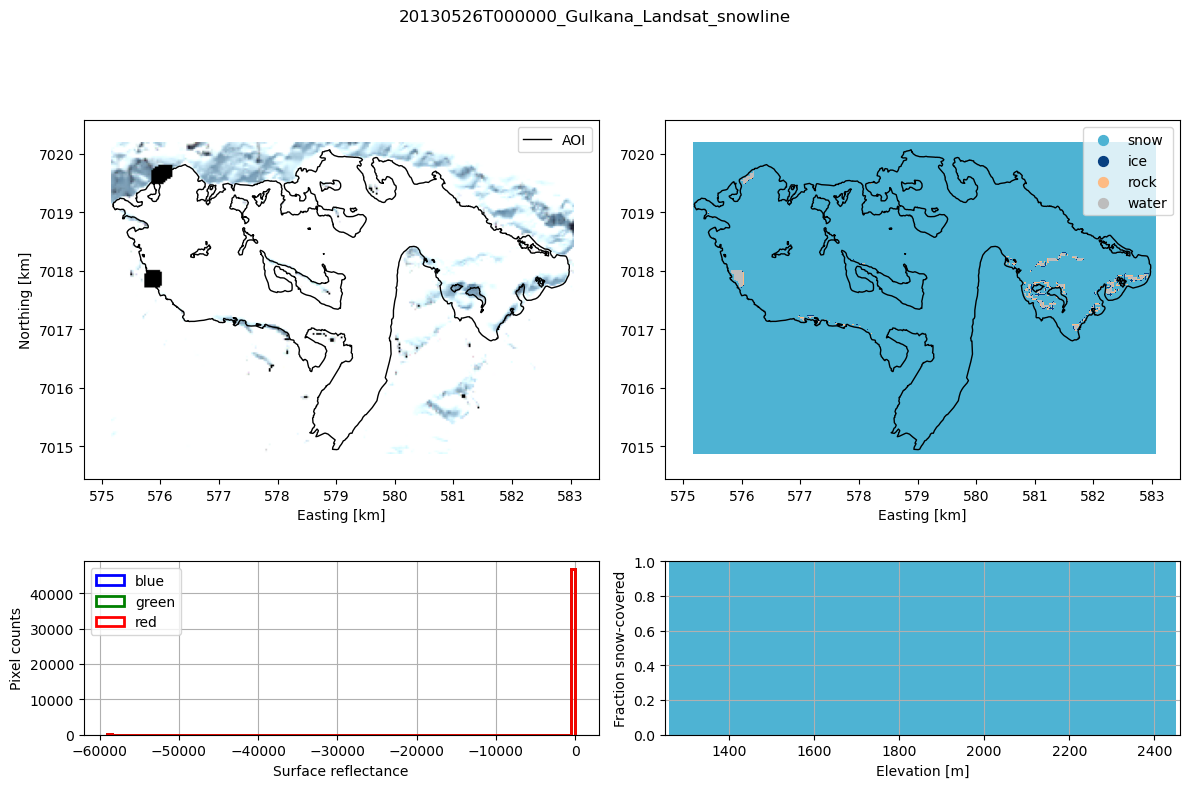

Median snowline elevation: 1266.186 m
Classified image already exists in file, continuing...
Snowline already exists in file, continuing...
Classified image already exists in file, continuing...


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_24152/456842864.py:49: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  im_xr = im_xr.isel(time=0)


[1960.83554885 1958.91602819 1958.25579353 ... 1274.26472393 1272.79542116
 1274.71820356]
[1960.83554885 1958.91602819 1958.25579353 ... 1274.26472393 1272.79542116
 1274.71820356]
Snowline saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Gulkana/AOIs/../imagery/snowlines/20130528T000000_Gulkana_Landsat_snowline.csv


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_24152/456842864.py:222: RuntimeWarning: invalid value encountered in scalar divide
  AAR = SCA / total_area
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Figure saved to file:/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Gulkana/AOIs/../figures/20130528T000000_Gulkana_Landsat_snowline.png


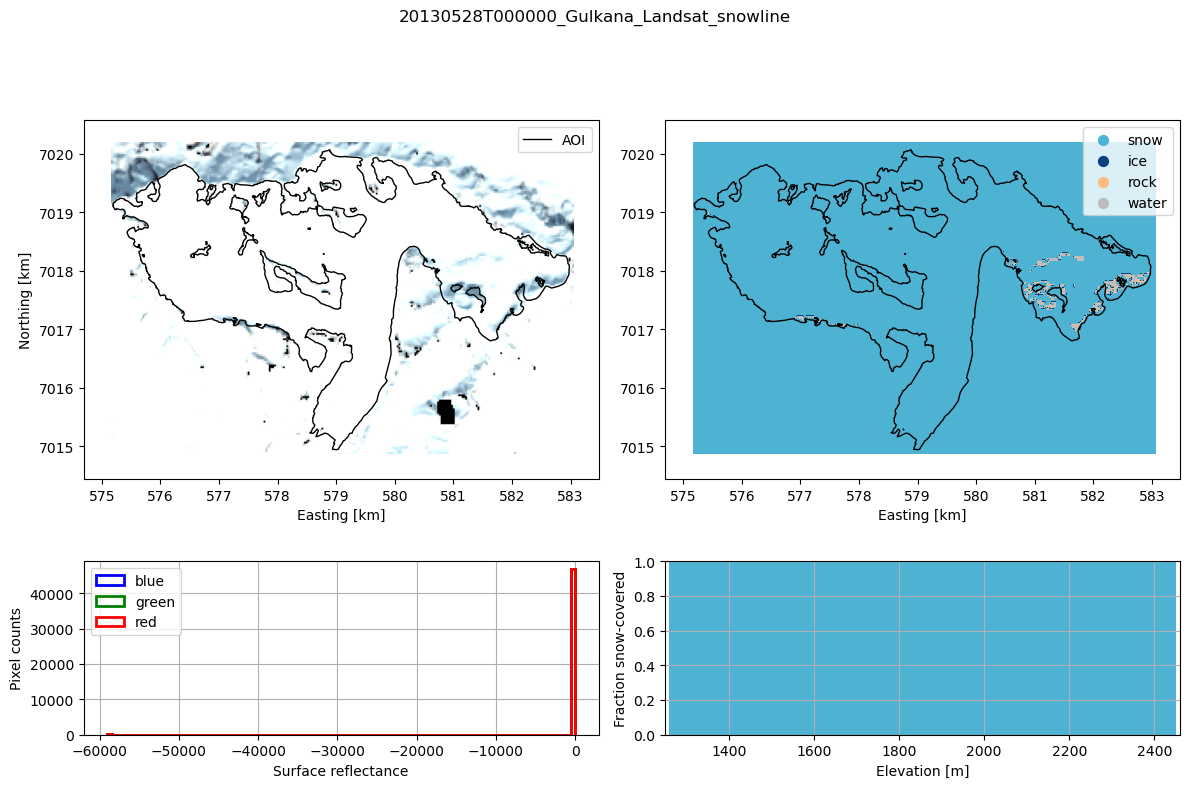

Median snowline elevation: 1266.186 m
Classified image already exists in file, continuing...


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_24152/456842864.py:49: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  im_xr = im_xr.isel(time=0)


[1969.83077731 1963.47673264 1960.29337799 ... 1274.26472393 1272.79542116
 1274.71820356]
[1960.83554885 1958.91602819 1958.25579353 ... 1274.26472393 1272.79542116
 1274.71820356]
Snowline saved to file: /Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Gulkana/AOIs/../imagery/snowlines/20130611T000000_Gulkana_Landsat_snowline.csv


/var/folders/9h/sg2rw9f10lq5jmfch9hnj6gc0000gq/T/ipykernel_24152/456842864.py:222: RuntimeWarning: invalid value encountered in scalar divide
  AAR = SCA / total_area
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Figure saved to file:/Users/raineyaberle/Google Drive/My Drive/Research/PhD/snow_cover_mapping/study-sites/Gulkana/AOIs/../figures/20130611T000000_Gulkana_Landsat_snowline.png


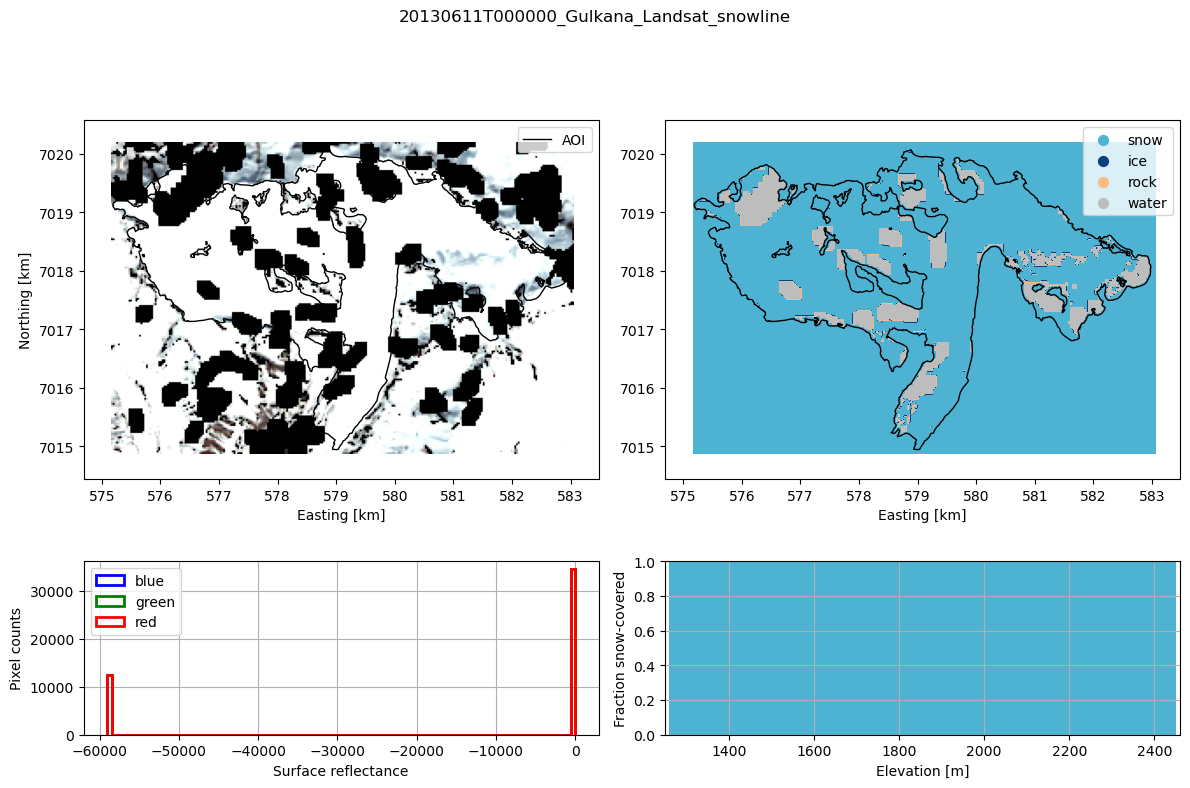

Median snowline elevation: 1266.186 m


In [31]:
# -----Load trained classifier and feature columns
# clf_fn = base_path+'inputs-outputs/Landsat_classifier_all_sites.joblib'
# clf = load(clf_fn)
# feature_cols_fn = base_path+'inputs-outputs/Landsat_feature_cols.pkl'
# feature_cols = pickle.load(open(feature_cols_fn,'rb'))

# # -----Query GEE for imagery
# dataset = 'Landsat'
# im_list = f.query_GEE_for_Landsat_SR(AOI_UTM, date_start, date_end, month_start, month_end, 
#                                     cloud_cover_max, mask_clouds, L_im_path)

# -----Loop through images
if type(im_list)==str: # check that images were found
    print('No images found to classify, quiting...')
else:
    
    for i in tqdm(range(0, len(im_list))):
        
        # -----Subset image using loop index
        im_xr = im_list[i]
        im_date = str(im_xr.time.data[0])
        
        # -----Adjust image for image scalar and no data values
        # replace no data values with NaN and account for image scalar
        crs = im_xr.rio.crs.to_epsg()
        im_xr = xr.where(im_xr==dataset_dict[dataset]['no_data_value'], np.nan, 
                         im_xr / dataset_dict[dataset]['image_scalar'])
        # add NDSI band
        im_xr['NDSI'] = ((im_xr[dataset_dict[dataset]['NDSI_bands'][0]] - im_xr[dataset_dict[dataset]['NDSI_bands'][1]]) 
                             / (im_xr[dataset_dict[dataset]['NDSI_bands'][0]] + im_xr[dataset_dict[dataset]['NDSI_bands'][1]]))
        im_xr.rio.write_crs('EPSG:'+str(crs), inplace=True)
                
        # -----Classify image
        # check if classified image already exists in file
        im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
        if os.path.exists(im_classified_path + im_classified_fn):
            print('Classified image already exists in file, continuing...')
            im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        else:  
            # classify image
            im_classified = f.classify_image(im_xr, clf, feature_cols, crop_to_AOI, 
                                             AOI_UTM, dataset, dataset_dict, site_name, 
                                             im_classified_fn, im_classified_path)
            if type(im_classified)==str: # skip if error in classification
                continue
        
        # -----Delineate snowline(s)
        # check if snowline already exists in file
        snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.csv'
        if os.path.exists(snowlines_path + snowline_fn):
            print('Snowline already exists in file, continuing...')
            continue # no need to load snowline if it already exists
        else:
            plot_results = True
            # create directory for figures if it doesn't already exist
            if (os.path.exists(figures_out_path)==False) & (plot_results==True):
                os.mkdir(figure_out_path)
                print('Created directory for output figures: '+figures_out_path)
            snowline_df = delineate_im_snowline(im_xr, im_classified, site_name, AOI_UTM, DEM, 
                                                  dataset_dict, dataset, im_date, snowline_fn, 
                                                  snowlines_path, figures_out_path, plot_results)
            plt.show()
            print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

## 4. PlanetScope SR

In [ ]:
# -----Load trained classifier and feature columns
clf_fn = base_path+'inputs-outputs/PS_classifier_all_sites.sav'
clf = pickle.load(open(clf_fn, 'rb'))
feature_cols_fn = base_path+'inputs-outputs/PS_feature_cols.pkl'
feature_cols = pickle.load(open(feature_cols_fn,'rb'))
dataset = 'PlanetScope'

# -----Read surface reflectance file names
os.chdir(PS_im_path)
im_fns = sorted(glob.glob('*SR*.tif'))
plot_results = True

# ----Mask clouds and cloud shadows in all images
if mask_clouds:
    print('Masking images using cloud bitmask...')
    for i, im_fn in tqdm(enumerate(im_fns)):
        f.PS_mask_im_pixels(PS_im_path, im_fn, PS_im_masked_path, save_outputs, plot_results)
    # read masked image file names
    os.chdir(PS_im_masked_path)
    im_masked_fns = glob.glob('*_mask.tif')
    im_masked_fns = sorted(im_masked_fns) # sort chronologically
    
# -----Mosaic images captured within same hour
print('Mosaicking images captured in the same hour...')
if mask_clouds: 
    f.PS_mosaic_ims_by_date(PS_im_masked_path, im_masked_fns, PS_im_mosaics_path, AOI_UTM, plot_results)
    print(' ')
else:
    f.PS_mosaic_ims_by_date(PS_im_path, im_fns, PS_im_mosaics_path, AOI_UTM, plot_results)
    print(' ')
    
# -----Adjust image radiometry
# read mosaicked image file names
os.chdir(PS_im_mosaics_path)
im_mosaic_fns = glob.glob('*.tif')
im_mosaic_fns = sorted(im_mosaic_fns)
# create a polygon(s) of the top 20th percentile elevations within the AOI
plot_results=False 
polygon_top, polygon_bottom, im_mosaic_fn, im_mosaic = f.create_AOI_elev_polys(AOI_UTM, PS_im_mosaics_path, im_mosaic_fns, DEM)
# loop through images
for i, im_mosaic_fn in tqdm(enumerate(im_mosaic_fns)):
    # adjust radiometry
    im_adj, im_adj_method = f.PS_adjust_image_radiometry(im_mosaic_fn, PS_im_mosaics_path, polygon_top, 
                                                         polygon_bottom, AOI_UTM, dataset_dict, dataset, 
                                                         site_name, skip_clipped, plot_results)
    if type(im_adj)==str: # skip if there was an error in adjustment
        continue
    
    # -----Determiine image date
    im_date = im_mosaic_fn[0:8] + 'T' + im_mosaic_fn[9:11] + ':00:00'
    
    # -----Classify image
    im_classified_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_classified.nc'
    if os.path.exists(im_classified_path + im_classified_fn):
        print('Classified image already exists in file, loading...')
        im_classified = xr.open_dataset(im_classified_path + im_classified_fn)
        im_classified = im_classified.where(im_classified!=-9999)
        im_classified.classified.data = im_classified.classified.data.astype(float)
    else:
        im_classified = f.classify_image(im_adj, clf, feature_cols, crop_to_AOI, 
                                         AOI_UTM, dataset, dataset_dict, site_name, 
                                         im_classified_fn, im_classified_path)

    if type(im_classified)==str:
        continue    
    
    # -----Delineate snowline(s)
    plot_results=True
    # create directory for figures if it doesn't already exist
    if (os.path.exists(figures_out_path)==False) & (plot_results==True):
        os.mkdir(figure_out_path)
        print('Created directory for output figures: '+figures_out_path)
    # check if snowline already exists in file
    snowline_fn = im_date.replace('-','').replace(':','') + '_' + site_name + '_' + dataset + '_snowline.pkl'
    if os.path.exists(snowlines_path + snowline_fn):
        print('Snowline already exists in file, loading...')
        snowline_df = pd.read_pickle(snowlines_path + snowline_fn)
    else:
        snowline_df = f.delineate_im_snowline(im_adj, im_classified, site_name, AOI_UTM, DEM, 
                                              dataset_dict, dataset, im_date, snowline_fn, 
                                              snowlines_path, figures_out_path, plot_results)
        plt.show()
    print('Median snowline elevation: ' + str(snowline_df['snowlines_elevs_median'][0]) + ' m')

## _Optional_: Compile individual figures into a single .gif file

In [ ]:
### Modify the strings below according to your file names ###

# identify the string that is present in all filenames of the figures that you want to compile
fig_fns_str = '*' + site_name + '_' + dataset + '_*snowline.png'
# define the output .gif filename
gif_fn = site_name + '_' + dataset + '_' + date_start.replace('-','') + '_' + date_end.replace('-','') + '_snowlines.gif' 

# -----Make a .gif of output images
from PIL import Image as PIL_Image
from IPython.display import Image as IPy_Image
os.chdir(figures_out_path)
fig_fns = glob.glob(fig_fns_str) # load all output figure file names
fig_fns = sorted(fig_fns) # sort chronologically

# grab figures date range for .gif file name
frames = [PIL_Image.open(im) for im in fig_fns]
frame_one = frames[0]
frame_one.save(figures_out_path + gif_fn, format="GIF", append_images=frames, save_all=True, duration=2000, loop=0)
print('GIF saved to file:' + figures_out_path + gif_fn)


# -----Clean up: delete individual figure files
for fn in fig_fns:
    os.remove(os.path.join(figures_out_path, fn))
print('Individual figure files deleted.')

# -----Display .gif
IPy_Image(filename = figures_out_path + gif_fn)